In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import json
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from einops import repeat
from models.cvae import CVAEv1, CVAEv2

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v2'
split = 'random'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_1476029/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


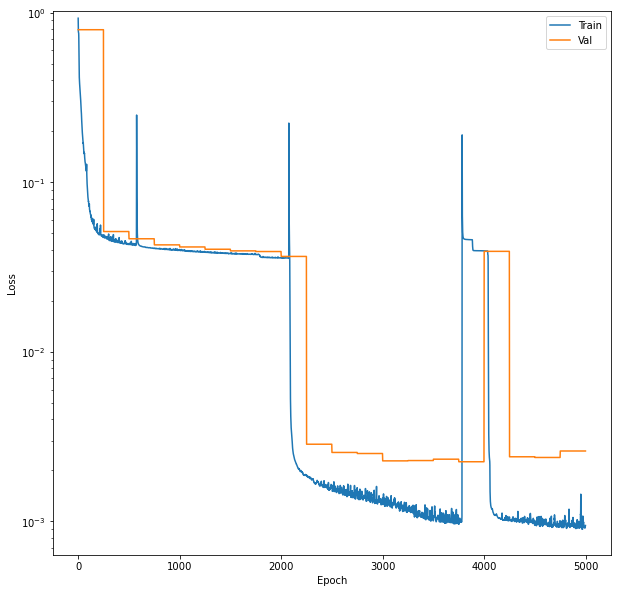

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Load model
model = CVAEv2()
model.load_state_dict(torch.load(f'runs/{model_type}/{split}/{fname}/best_model.pt', map_location=configs['device']))
model = model.to(configs['device'])
model.eval()

# Load test set
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, test_dataset = dataset.train_val_test_split(mode='random', both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

# Get test zeolites and OSDAs
zeo, osda = test_dataset[5], test_dataset[15]

# Predict synthesis conditions
zeo = repeat(zeo, 'n d -> (repeat n) d', repeat = 50)
osda = repeat(osda, 'n d -> (repeat n) d', repeat = 50)
zeo, osda = zeo.to(configs['device']), osda.to(configs['device'])
syn_pred = torch.tensor(model.predict(zeo, osda).cpu().detach().numpy())

# Scale synthesis conditions back
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
syn_pred.to_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv', index=False) # Save synthetic predictions
syn_pred

n_datapoints:
train: 15416 val: 2203 test: 4405


,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time
0,10.000000,1.717997,99.0,250.0,0.000000,0.0,0.000000,0.0,12.500000,0.120962,170.0,288.0
1,41.852253,1.717997,99.0,250.0,0.000000,0.0,0.000000,0.0,88.741318,0.000000,200.0,6.0
2,400.000000,0.000000,99.0,250.0,0.000000,0.0,0.000000,0.0,7.060061,0.280455,140.0,168.0
3,400.000000,0.000000,99.0,250.0,0.159798,0.0,0.112395,0.0,15.000000,0.259547,160.0,168.0
4,20.000000,1.717997,99.0,250.0,0.000000,0.0,0.000000,0.0,9.677940,0.000000,160.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
220245,32.339211,1.717997,99.0,250.0,0.098797,0.0,0.000000,0.0,49.063274,1.304348,160.0,168.0
220246,18.181999,1.000000,99.0,250.0,0.000000,0.0,0.000000,0.0,0.000000,0.149970,170.0,168.0
220247,400.000000,0.000000,99.0,250.0,0.000000,0.0,0.000000,0.5,14.049436,0.450340,175.0,288.0
220248,0.000000,1.717997,0.0,0.0,0.000000,0.0,0.087781,0.0,9.374707,0.113855,150.0,168.0


In [6]:
# Get ground truth
syn_true = test_dataset[1]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time
0,400.0000,0.000000,99.000000,10.000007,0.018182,0.0,0.000000,0.000000,27.272728,0.272727,170.0,168.000000
1,30.0000,1.717997,99.000000,250.000000,0.290323,0.0,0.232258,0.000000,9.677419,0.000000,160.0,240.000000
2,1.0000,1.717997,99.000000,250.000000,0.250000,0.0,2.333332,0.000000,26.666666,2.083333,100.0,50.000000
3,400.0000,0.000000,2.030304,66.999977,0.000000,0.0,0.000000,0.247525,2.970297,0.247525,170.0,24.000000
4,0.5000,1.717997,99.000000,250.000000,1.920999,0.0,2.434168,0.000000,63.369980,0.000000,180.0,504.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4400,150.0504,1.717997,99.000000,250.000000,0.100005,0.0,0.243345,0.000000,43.468693,0.143340,170.0,59.179119
4401,0.0500,1.111111,99.000000,250.000000,0.000000,0.0,0.000000,0.128205,12.820513,0.212821,180.0,2.000000
4402,400.0000,0.000000,99.000000,250.000000,0.000000,0.0,0.000000,0.500000,7.250000,0.500000,175.0,96.000000
4403,0.0000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.825000,3.124996,170.0,168.000000


# Aggregated

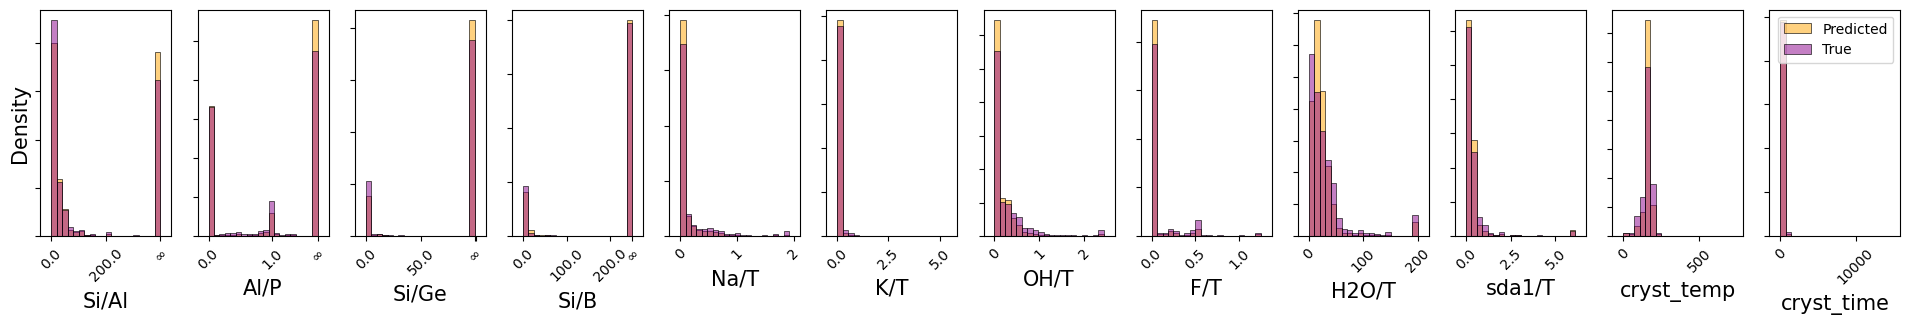

In [7]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], ['orange', 'darkmagenta'], kde=False, common_norm=True, alpha=0.5)